# Brainstation Final Project, Toronto Housing Prices

In [201]:
# Dropped the imports down to here for use from this point
from typing import Union

import pandas as pd
import numpy as np

import ast

import re

import h3

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default = "vscode"

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.cluster import KMeans

pd.set_option('plotting.backend', 'plotly')
pd.options.mode.chained_assignment = None  # default='warn'

## Loading the Datasets

I scraped 3 sites, all of which have similar listings. I will choose which one to use based on some factors.

In [2]:
trreb = pd.read_csv('data/trreb-jan17.csv', parse_dates=['added_at'])
realtor = pd.read_csv('data/realtorca-jan17.csv')
zoocasa = pd.read_csv('data/zoocasa-jan17.csv', parse_dates=['added_at'])

In [3]:
f"Dataset # of Rows: Trreb: {trreb.shape[0]}, Realtor.ca: {realtor.shape[0]}, Zoocasa: {zoocasa.shape[0]}"

'Dataset # of Rows: Trreb: 1495, Realtor.ca: 4046, Zoocasa: 3856'

Trreb has far less entries than the other two so I will not be using it for the model.

In [4]:
# Zoocasa has entries with "0 Room totals"
zoocasa['rooms_total'].replace(0.0, np.nan, inplace=True)

In [5]:
# Realtor.ca has more entries but also an inconvenient issue where the internal square footage is not included, but the room dimensions are
# this wouldn't be too hard to calculate but some rooms are missing, which was yield skewed results with our model.
realtor['room_dim_list'][0]

"19'4'' x 11'5'',14'8'' x 8'4'',8'9'' x 11'9'',4'10'' x 5'6'',5'5'' x 4'5'',15'0'' x 11'9''"

In [6]:
# Instead of a NaN value, the dataset comes out like this for rooms without available dimensions so I need to fix that.
realtor.room_dim_list[117]

'Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available'

In [7]:
realtor['room_dim_list_fixed'] = realtor['room_dim_list'].str.replace('Measurements not available,', '').replace('Measurements not available', '')
realtor['room_dim_list_fixed'].replace('', np.nan, regex=True, inplace=True)
realtor.room_dim_list_fixed[117]

nan

In [8]:
z_potential_features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'bathrooms_partial', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'garage_type', 'exterior', 'driveway_type', 'basement_type', 'features', 'levels', 'rooms_total', 'desc']
r_potential_features = ['price', 'bedrooms', 'bathrooms', 'archi_style', 'room_dim_list_fixed', 'parking', 'parking_type','type', 'exterior', 'utility', 'basement_type', 'features', 'levels', 'rooms_total', 'public_desc', 'heating', 'land_total']

## Counting NaN Values to Compare Datasets

In [9]:
# Realtor.ca
fig = px.bar(
    data_frame=realtor[r_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Realtor.ca NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

# Zoocasa
fig = px.bar(
    data_frame=zoocasa[z_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Zoocasa NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

Realtor.ca is missing almost all of its parking data, as well as its levels and architectural style. I believe these will be pretty essential for my model. As for the square footage, it is pretty similar for both sets of data. From this alone, I have chosen to use the Zoocasa data

In [10]:
# Second Zoocasa dataset, partially scraped 9 days after the first one.
zoocasa_2 = pd.read_csv('data/zoocasa-jan26.csv', parse_dates=['added_at'])
zoocasa_2['rooms_total'].replace(0.0, np.nan, inplace=True)

In [11]:
zoocasa_concat = pd.concat([zoocasa, zoocasa_2], axis=0)
zoocasa_concat.drop_duplicates(subset='mls_num', keep='first', inplace=True)
zoocasa_concat.reset_index(drop=True, inplace=True)
f"Second scrape added: {zoocasa_concat.shape[0] - zoocasa.shape[0]} listings"

'Second scrape added: 485 listings'

In [21]:
# Removing all listings added before 2022, not relevant
df = zoocasa_concat[(zoocasa_concat['added_at'].dt.year == 2022) | (zoocasa_concat['added_at'].dt.year == 2023)]

In [22]:
df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
df = df[~df['rooms_total'].isna()]

In [23]:
df['fsa'] = df['postal_code'].str.slice(0,3)
df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)

In [24]:
df['fsa'].unique()

array(['M9M', 'M5A', 'M8V', 'M4S', 'M6M', 'M5S', 'M4Y', 'M1G', 'M4P',
       'M8Y', '000', 'M6P', 'M6E', 'M4V', 'M1E', 'M4L', 'M8X', 'M6K',
       'M2J', 'M5P', 'M5V', 'M4C', 'M1W', 'M5E', 'M1P', 'M9N', 'M2N',
       'M3A', 'M5R', 'M9R', 'M2R', 'M1M', 'M2M', 'M9V', 'M5J', 'M4W',
       'M1S', 'M4E', 'M6L', 'M6N', 'M6C', 'M9B', 'M3C', 'M1K', 'M3N',
       'M6B', 'M1B', 'M1J', 'M8Z', 'M9A', 'M6R', 'M1R', 'M3M', 'M8W',
       'M5M', 'M5G', 'M5T', 'M5B', 'M5C', 'M6J', 'M2H', 'M9C', 'M3J',
       'M2K', 'M6H', 'M3H', 'M4N', 'M4A', 'M9L', 'M6S', 'M4G', 'M6G',
       'M1N', 'M6A', 'M3K', 'M4K', 'M2P', 'M9W', 'M1T', 'M1V', 'M2L',
       'M1H', 'M4M', 'M3B', 'M5H', 'M1L', 'M9P', 'M5N', 'M4R', 'M1C',
       'M2S', 'M4T', 'M4B', 'M4H', 'M4J', 'M4X', 'M1X', 'L4J', 'TBA',
       'M3L', 'XXX', 'L9J', 'M2E', 'L1T', 'L9Y'], dtype=object)

In [25]:
df = df[df['fsa'] != 'XXX']

In [26]:
df.loc[:,~df.columns.isin(['id', 'bathrooms_partials', 'bedrooms_partials', 'lat', 'lon', 'neighbourhood_id'])].describe()

,price,bedrooms,bedrooms_partial,bathrooms,bathrooms_partial,square_footage_min,square_footage_max,parking,rooms_total
count,3.147000e+03,3147.000000,3147.000000,3147.000000,4.00,3147.000000,3147.000000,3143.000000,3147.000000
mean,1.073980e+06,1.935176,0.464887,1.959009,0.25,1027.281220,1250.650143,1.535635,6.276772
std,9.484472e+05,1.008038,0.584519,1.088534,0.50,702.009717,866.576028,13.159508,2.196044
min,1.000000e+00,0.000000,0.000000,1.000000,0.00,0.000000,499.000000,0.000000,1.000000
25%,6.194440e+05,1.000000,0.000000,1.000000,0.00,600.000000,699.000000,1.000000,5.000000
50%,7.589000e+05,2.000000,0.000000,2.000000,0.00,900.000000,999.000000,1.000000,6.000000
75%,1.139000e+06,2.000000,1.000000,2.000000,0.25,1200.000000,1399.000000,1.000000,7.000000
max,1.777500e+07,9.000000,5.000000,8.000000,1.00,4750.000000,5000.000000,706.000000,13.000000


The parking maximum is way too high and the minimum price is far too low. So I will have to clean those up

In [27]:
# deleting any parking number that is above 3 standard deviations from the mean. 
# There are no negative "parking spots" so I only need to check in the positive direction
df = df[df['parking'] < (df['parking'].describe()['std']*3 + df['parking'].describe()['mean'])]
df['parking'].describe()

count    3139.000000
mean        1.207232
std         1.296223
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: parking, dtype: float64

In [28]:
# I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
df = df[df['price'] > 200000]
df['price'].describe()

count    3.135000e+03
mean     1.076010e+06
std      9.493386e+05
min      2.340000e+05
25%      6.199000e+05
50%      7.590000e+05
75%      1.142400e+06
max      1.777500e+07
Name: price, dtype: float64

In [29]:
f"# of Valid Rows: {df.shape[0]}"

'# of Valid Rows: 3135'

In [30]:
import plotly.graph_objects as go

fig = px.scatter_mapbox(df, lat='lat', lon='lon', color='price',
             color_continuous_scale= [
                [0.0, "green"],
                [0.05, "green"],
                [0.05111111, "yellow"],
                [0.11111111, "yellow"],
                [0.11111112, "red"],
                [1, "red"]],
                opacity = 0.5,
                hover_name="address", 
                hover_data=["square_footage_min", "square_footage_max", "type", "levels", "bedrooms", "bathrooms"]
            )

fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

We are already beginning to see some patterns in terms of location. The locations surrounding yonge street seem consistently higher priced than those in other areas. As well there is a more dense area of listings towards the centre of the visualization and a large group in the southern portion (downtown Toronto)

## Grouping Common Values
For the language portions of the data, a lot of the categories can be grouped together. I will be looking at the unique values in a couple different columns and grouping them together if they are similar enough / they are not confounding.

In [31]:
df['type'].value_counts()

Condo Apt             2409
Detached               272
Condo Townhouse        223
Comm Element Condo      77
Semi-Detached           60
Att/Row/Twnhouse        40
Co-Op Apt               15
Co-Ownership Apt        11
Leasehold Condo          8
Triplex                  5
Duplex                   4
Multiplex                3
Store W/Apt/Offc         2
Attached                 2
Link                     1
Fourplex                 1
Det Condo                1
Name: type, dtype: int64

In [32]:
df['type'].replace(['Comm Element Condo', 'Det Condo', ], 'Condo Apt', inplace=True)
df['type'].replace(['Co-Ownership Apt'], 'Co-Op Apt', inplace=True)
df['type'].replace(['Duplex', 'Triplex', 'Fourplex'], 'Multiplex', inplace=True)
df = df[df['type'] != 'Store W/Apt/Offc']
df = df[df['type'] != 'Link']
df.type.value_counts()

Condo Apt           2487
Detached             272
Condo Townhouse      223
Semi-Detached         60
Att/Row/Twnhouse      40
Co-Op Apt             26
Multiplex             13
Leasehold Condo        8
Attached               2
Name: type, dtype: int64

In [33]:
df['levels'].replace('Bungalow-Raised', 'Bungalow', inplace=True)
df['levels'].replace(['Multi-Level', 'Condo/Apt Unit', 'Bachelor/Studio'], 'Apartment', inplace=True)
df = df[df['levels'] != "Other"]
df.levels.value_counts()

Apartment          2401
2-Storey            358
3-Storey            135
Stacked Townhse      75
Loft                 66
Bungalow             47
2 1/2 Storey         23
1 1/2 Storey         12
Sidesplit 4           4
Backsplit 4           3
Sidesplit 3           2
Backsplit 3           1
Sidesplit 5           1
Name: levels, dtype: int64

In [34]:
df.loc[df['basement_type'].str.contains('Apartment', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('None and Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Fin', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Finished', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Unfinished', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Part Bsmt', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Sep Entrance', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('W/O', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Walk-Up', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Full', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Half', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Crawl Space', na=False), 'basement_type'] = 'None'
df['basement_type'].value_counts()

None            2707
Finished         356
Unfinished        36
Sep Entrance      13
Name: basement_type, dtype: int64

In [35]:
numerical_features = ['bedrooms', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'rooms_total']

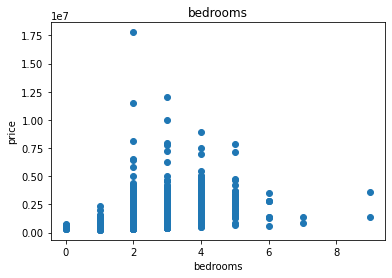

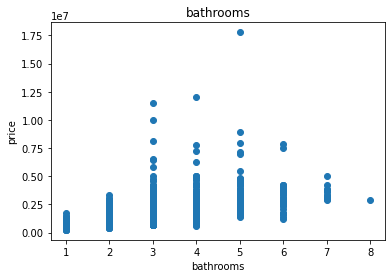

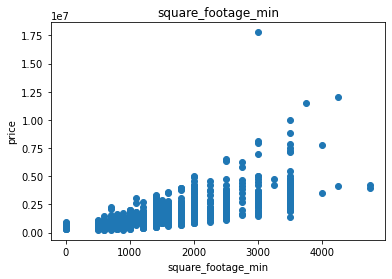

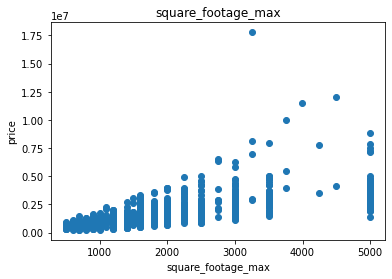

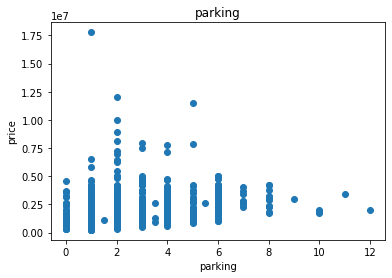

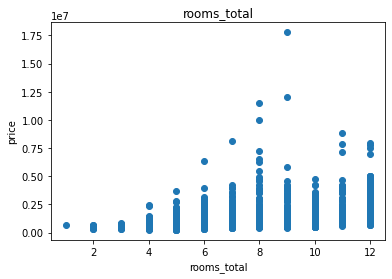

In [36]:
# a group of scatter plots to better visualize linear relationships between listing variables and price
for feature in numerical_features:
    plt.scatter(x=df[feature], y=df["price"])
    plt.title(feature)
    plt.ylabel('price')
    plt.xlabel(feature)
    plt.show()

There is a counterintuitive relationship here, which is that it seems the less parking spaces we have, the higher the price is. One explanation for this could be the correlation between parking spaces and whether or not a listing is a condo. Condos are generally cheaper than houses, but can have more parking spaces

In [37]:
f"{df['fsa'].nunique()} zones/neighbourhoods"

'104 zones/neighbourhoods'

In [38]:
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [39]:
fig = px.imshow(df[features].corr())
fig.show()

This shows that there is still a positive relationship with between parking and price, its just not one of the stronger ones

# Creating the Model!

## Model Notes:

First iteration of the model was 80% accurate. It included houses and only properties under 4 000 000 dollars.

In [40]:
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [41]:
model_df = df[features]
model_df = model_df[model_df['price'] <= 4000000].reset_index(drop=True)
X = model_df.drop(columns='price')
y = model_df['price']

In [42]:
X = pd.get_dummies(data=X, drop_first=True)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # test data

In [44]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [45]:
lr.fit(X_train, y_train)

LinearRegression()

In [46]:
c = lr.intercept_
m = lr.coef_

In [47]:
y_predictions = lr.predict(X_train)

In [50]:
# 70% accuracy including houses over $4000000, 80% excluding them
# 75% accuracy using segments instead of FSA
y_pred_test = lr.predict(X_test)
r2_score(y_test, y_pred_test)

0.7834649601829201

In [51]:
px.scatter(x=y_test, y=y_pred_test, trendline='ols')

## Thoughts

The exclusion of houses actually reduced the r2 score of our model (80% to 70%).

A linear regression model including only sqft and fsa has a 67% r squared score, only 3% less than including the other features.

Are there ways I can account for location without categorizing the listings by FSA and adding all of those features?

Ideas:
- Proximity to center of Toronto
- Look at stats to do with FSA / district (median household income)
- Proximity to schools and school ratings
- Proximity to TTC?
- Uber Hexagon clustering
- Unsupervised clustering using my dataset in general?

Also heating and heating type + Kitchen size?

I looked through the Zoocasa data once again and I have decided to touch up my scraper a bit to include more pertinent info. I think that Zoocasa provides data on schools / neighbourhood data. I found that you can scrape all of the sold listings too. So I have done that and will combine the datasets

# Let's Make Some Functions!

The first few functions will be the data loading & cleaning functions

These include: format_zoocasa(), group_zoocasa(), concat_zoocasa() and load_zoocasa()

In [114]:
def format_zoocasa(df: pd.DataFrame, condos_only: bool = False, houses_only: bool = False, H3_res : int = 7) -> pd.DataFrame:
    """This function formats the scraped Zoocasa data in numerous ways.

    Args:
        df (pd.DataFrame): your scraped Zoocasa dataframe
        condos_only (bool): keep only condos
        houses_only (bool): keep only houses
        H3_res (int): resolution of H3 segmentation. Default 7

    Returns:
        pd.DataFrame: a formatted Zoocasa dataframe
    """
    # replacing 0 room totals with NaN values
    df['rooms_total'].replace(0.0, np.nan, inplace=True)

    # Removing all listings added before 2022, not relevant
    df = df[(df['added_at'].dt.year == 2022) | (df['added_at'].dt.year == 2023)]

    # Removing all null sqft and total rooms
    df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
    df = df[~df['rooms_total'].isna()]

    # Creating a square footage column with the average of min and max
    df['square_footage'] = df[['square_footage_min', 'square_footage_max']].mean(axis=1)

    # Filling partial bedroom nulls with 0
    df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)
    
    # adding all partial bedrooms to bedrooms column with half value
    df['bedrooms'] = df['bedrooms'] + (df['bedrooms_partial']/2)

    # Creating FSA Column
    df['fsa'] = df['postal_code'].str.slice(0,3)
    df = df[(df['fsa'] != 'XXX') & (df['fsa'] != 0) & (df['fsa'] != 000)] # if listing has no postal code

    # Formatting lot frontage and lot depth (For houses)
    df['lot_frontage'].fillna(0, inplace=True)
    df['lot_frontage'] = df['lot_frontage'].apply(lambda x : int(re.search(r'\d+', str(x)).group()))
    df['lot_depth'].fillna(0, inplace=True)
    df['lot_depth'] = df['lot_frontage'].apply(lambda x : int(re.search(r'\d+', str(x)).group()))


    def geo_to_h3(row):
      return h3.geo_to_h3(lat=row.lat,lng=row.lon,resolution = H3_res)
    df['h3_cell'] = df.apply(geo_to_h3,axis=1)

    # Creating a distance from Toronto column
    df['dis_from_tor'] = df.apply(lambda x : h3.point_dist((x['lat'], x['lon']), (43.7064, -79.3986), unit='m'), axis=1)

    # deleting any parking number that is above 2 standard deviations from the mean. 
    # There are no negative "parking spots" so I only need to check in the positive direction
    df = df[df['parking'] < (df['parking'].describe()['std']*2 + df['parking'].describe()['mean'])]

    # I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
    df = df[df['price'] > 200000]

    df = group_zoocasa(df, condos_only, houses_only)

    return df


def group_zoocasa(df: pd.DataFrame, condos_only: bool = False, houses_only: bool = False) -> pd.DataFrame:
    """Groups together the 'type' and 'levels' columns to reduce number of features.

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        condos_only (bool): if only condos in dataframe
        houses_only (bool): if only houses in dataframe

    Returns:
        pd.DataFrame: _description_
    """

    # Included Condo Types: Condo Apt, Condo Townhouse, Comm Element Condo, Co-Ownership Apt, Leasehold Condo
    # Included Levels: Apartment, 2-Storey, Stacked Townhse, Loft, 3-Storey, Multi-Level, Bachelor/Studio

    df['type'].replace(['Comm Element Condo'], 'Condo Apt', inplace=True)

    if condos_only:
        type_keep = ['Condo Apt', 'Condo Townhouse', 'Co-Ownership Apt', 'Leasehold Condo']
        levels_keep = ['Apartment', '2-Storey', 'Stacked Townhse', 'Loft', '3-Storey', 'Multi-Level', 'Bachelor/Studio']
    elif houses_only:
        type_keep = ['Semi-Detached', 'Detached', 'Duplex', 'Triplex', 'Fourplex', 'Att/Row/Twnhouse', 'Attached']
        levels_keep = ['Bungalow-Raised', 'Bungalow', '2-Storey', '2 1/2 Storey', '3-Storey', '1 1/2 Storey', 'Backsplit 4', 'Backsplit 3', 'Sidesplit 4', 'Sidesplit 3', 'Stacked Townhse', '3-Storey', 'Backsplit 5']
    else:
        type_keep = ['Condo Apt', 'Condo Townhouse', 'Comm Element Condo', 'Co-Ownership Apt', 'Leasehold Condo', 'Semi-Detached', 'Detached', 'Duplex', 'Triplex', 'Fourplex', 'Att/Row/Twnhouse', 'Attached']
        levels_keep = ['Apartment', '2-Storey', 'Stacked Townhse', 'Loft', '3-Storey', 'Bachelor/Studio', 'Bungalow-Raised', 'Bungalow', '2 1/2 Storey', '1 1/2 Storey', 'Backsplit 4', 'Backsplit 3', 'Sidesplit 4', 'Sidesplit 3', 'Stacked Townhse', '3-Storey', 'Backsplit 5']
    
    df = df[df['type'].isin(type_keep)]
    df = df[df['levels'].isin(levels_keep)]

    return df


def concat_zoocasa(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """concats multiple zoocasa dataframes and drops duplicate listing by MLS num

    Args:
        dfs (list): list of dataframes to concat

    Returns:
        pd.DataFrame: _description_
    """
    df = pd.concat(dfs, axis=0)
    df.drop_duplicates(subset='mls_num', keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


def load_zoocasa(data_loc: list[str]) -> Union[list[pd.DataFrame], pd.DataFrame]:
    """_summary_

    Args:
        data_loc (list[str]): list of strings indicating scraped data(s) from the Zoocasa scraper

    Returns:
        list[pd.DataFrame]: list of Pandas dataframes with the dates parsed
        pd.DataFrame: Pandas dataframe with the dates parsed
    """
    if len(data_loc) > 1:
        return [pd.read_csv(data, parse_dates=['added_at']) for data in data_loc]
    else:
        return pd.read_csv(data_loc[0], parse_dates=['added_at'])

The next few functions will be the model selection/validation/creation functions.

In [124]:
def prep_data(df: pd.DataFrame, features: list[str], price_cap: int) -> tuple[pd.DataFrame, pd.Series]:
    model_df = df[features]
    model_df = model_df[model_df['price'] <= 4000000].reset_index(drop=True)
    X = model_df.drop(columns='price')
    y = model_df['price']
    X = pd.get_dummies(data=X, drop_first=True)

    return X, y
    

def create_model(df: pd.DataFrame, features: list[str], model: any, price_cap: int = 4000000, random_state: int = 42, test_size: int = 0.3) -> tuple[any, dict[str, pd.DataFrame]]:
    """creates a regression model based on inputted data

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        features (list): list of features to include in the model (include price as well)
        model (any): sklearn model to use
        model_args (dict): arguments for model
        price_cap (int): price ceiling of listings to include in model
        random_state (int): desired random_state of split ex. 0, 1, 42
        test_size (int): desired test_size of split

    Returns:
        any: regression model
        list[pd.DataFrame]: dict of val dataframes
    """
    X, y = prep_data(df, features, price_cap)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=0) # val data

    split = {
        'X_val' : X_val,
        'y_val' : y_val,
        'X_train' : X_train,
        'y_train' : y_train
    }

    return model.fit(X_train, y_train), split


def cv_kfold(df: pd.DataFrame, features: list[str], model: any, n_splits: int = 5, price_cap: int = 4000000) -> str:
    """Get the kfold cross validation score for model

    Args:
        df (pd.DataFrame): Zoocasa pandas dataframe
        features (list[str]): feature list (including price)
        model (any): your regression model
        n_splits (int, optional): amount of splits of the kfold. Defaults to 5.
        price_cap (int, optional): maximum listing price. Defaults to 4000000.

    Returns:
        str: Kfold Cross Validation Scores
    """
    X, y = prep_data(df, features, price_cap=price_cap)

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    return {'Total Scores' : scores, 'Mean Score' : sum(scores)/n_splits}


def predict(val_data: dict[str: pd.DataFrame], model: any) -> tuple[np.ndarray, np.ndarray]:
    """Generates the test predictions from regression model and R2 scores

    Args:
        val_data (dict): validation data from split
        model (any): Regression model

    Returns:
        tuple[np.ndarray]: predictions on train and test data
    """

    y_train_predictions = model.predict(val_data['X_train'])
    y_test_predictions = model.predict(val_data['X_val'])

    return y_train_predictions, y_test_predictions

## Taking a look at the new dataset

In [116]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [117]:
df.shape # ~6 times more valid listings than the last dataset

(18785, 41)

In [118]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'heating', 'heating_fuel', 'lot_frontage',
       'lot_depth', 'ac', 'exterior', 'driveway_type', 'basement_type', 'levels', 'rooms_total', 'rooms_dimensions', 'fsa', 'dis_from_tor']

df[features].describe()

,price,bedrooms,bathrooms,square_footage,parking,lot_frontage,lot_depth,rooms_total,dis_from_tor
count,1.878500e+04,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000,18785.000000
mean,9.743641e+05,2.145994,1.866809,1086.375752,1.265691,5.412031,5.412031,6.351770,7822.790199
std,7.163877e+05,1.078846,1.012243,708.353062,1.300532,14.279474,14.279474,2.262335,3706.560137
min,2.340000e+05,0.000000,1.000000,249.500000,0.000000,0.000000,0.000000,1.000000,68.730589
25%,5.999000e+05,1.500000,1.000000,649.500000,1.000000,0.000000,0.000000,5.000000,5777.239960
50%,7.488000e+05,2.000000,2.000000,849.500000,1.000000,0.000000,0.000000,6.000000,7188.092206
75%,9.998880e+05,2.500000,2.000000,1299.500000,1.000000,0.000000,0.000000,7.000000,9740.784674
max,1.200000e+07,10.500000,11.000000,4874.500000,15.000000,166.000000,166.000000,12.000000,23731.095520


In [119]:
px.bar(df[features].corr()['price'], x=df[features].corr().index, y='price', labels={'price': 'Correlation', 'x' : 'Features'}, title='Correlation with Price')

This is another kind of visualization for correlation which I actually prefer over a heatmap.

Below I use the new functions to try out a linear regression model on the new dataset

In [120]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [121]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'rooms_total', 'type', 'levels', 'fsa']
cv_kfold(df, features, LinearRegression())

{'Total Scores': [0.8065565869838545,
  0.8102649693681793,
  0.7948733134955438,
  0.7965812355873882,
  0.8147405701307688],
 'Mean Score': 0.8046033351131469}

~81% R squared score with new dataset, no change with our linear regression model.

Lets try out Random Forest Regression

In [129]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'rooms_total', 'type', 'levels', 'fsa']
cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.81538476170624,
  0.838619115967041,
  0.8462202394228541,
  0.8558214453616922,
  0.8370412791068345],
 'Mean Score': 0.8386173683129323}

The Random Forest model shows slight improvement over the linear regression model

## Tuning Location in Model

Location, location, location. FSA is not necessarily a good measure for location.

Here I explore a couple of other different options to account for location

In [130]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

Adding distance from centre of Toronto as a metric, (yonge and eglinton)

In [133]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'fsa', 'dis_from_tor']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.8488362810786827,
  0.8723181571000383,
  0.8625448001882061,
  0.8792554134127477,
  0.8718749480088863],
 'Mean Score': 0.8669659199577122}

Distance from Toronto as a metric improved model accuracy by ~3%

In [134]:
# Uber's H3 Hexagon Clustering (This has been added to the format function)
# H3_res = 7
# def geo_to_h3(row):
#   return h3.geo_to_h3(lat=row.lat,lng=row.lon,resolution = H3_res)

# df['h3_cell'] = df.apply(geo_to_h3,axis=1)

In [135]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.8440735748932396,
  0.8664003213083197,
  0.8631158231589864,
  0.877710825472051,
  0.8663999295686406],
 'Mean Score': 0.8635400948802474}

No difference with Uber's H3 Hexagon Clustering

Also, K-Means Clustering does yields lower results than simple H3 and FSA

## Is general location now accounted for?

In [143]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'rooms_total',  'type', 'levels', 'h3_cell', 'dis_from_tor']

rf, split_data = create_model(df, model=RandomForestRegressor(random_state=42), features=features, price_cap=4000000)

y_train_predictions, y_test_predictions = predict(split_data, rf)

In [144]:
split_data['X_val']['price'] = split_data['y_val']
split_data['X_val']['price_predictions'] = y_test_predictions
split_data['X_val']['error'] = (abs(split_data['X_val']['price_predictions'] - split_data['X_val']['price']) / ((split_data['X_val']['price_predictions'] + split_data['X_val']['price'])/2))*100
error = pd.merge(split_data['X_val'], df)
fig = px.scatter_mapbox(error, lat='lat', lon='lon', color='error',
             color_continuous_scale= px.colors.sequential.Agsunset,
                opacity = 0.5,
                hover_name="address", 
                hover_data=["unit", "square_footage", "price", "price_predictions"],
                labels={'error': 'Abs % Error'}
            )

fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

The lighter the point, the higher the percentage of error my model has on the test data. The spread of high error points indicates to me that the model is sufficiently accounting for location

## Accounting for Date

Something that I probably should have tried earlier, was to account for date lmao. So I will explore that here

In [232]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [233]:
time_df = df.set_index('added_at')

In [234]:
time_g = time_df.groupby(pd.Grouper(freq='M'))['price'].mean().to_frame()
time_g.rename(columns={'price': 'mean_price'}, inplace=True)
time_g['median_price'] = time_df.groupby(pd.Grouper(freq='M'))['price'].median()

In [235]:
px.line(time_g, title="Mean and Median Price Over 2022", labels={'value' : 'Price', 'added_at' : 'Month'})

From this visualization we can see that date may be a confounding factor in price

In [5]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [240]:
df['epoch'] = pd.to_numeric(df.added_at.dt.strftime('%s'))

In [241]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor', 'epoch']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.8399794122122719,
  0.8614794702351048,
  0.8618874215032943,
  0.8752205926566687,
  0.8612464872054892],
 'Mean Score': 0.8599626767625658}

Including the epoch time as a feature has decreased the performance of the model, but the real estate market is cyclical. Maybe it would help to change the date into categorical features, such as season or month?

In [199]:
df['month_year'] = pd.to_datetime(df['added_at']).dt.to_period('M').astype(str)

/Users/henrybrown/opt/anaconda3/envs/data_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [249]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor', 'month_year']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.8451272101468674,
  0.8601628872977233,
  0.8652863489326827,
  0.875677173164837,
  0.861082037900057],
 'Mean Score': 0.8614671314884335}

In [197]:
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Fall',
               10: 'Fall',
               11: 'Fall',
               12: 'Winter'}
df['season'] = df['added_at'].apply(lambda x: f"{season_dict[x.month]} {x.year}")

In [7]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor', 'season']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.846011613556995,
  0.8609882971140996,
  0.8667057213972291,
  0.8778931499728782,
  0.8629852637474673],
 'Mean Score': 0.8629168091577339}

Accounting for date / time of year does not seem to improve the model

In [108]:
data_locations = ['data/zoocasa-feb-2-sold.csv']
df = load_zoocasa(data_locations)
df.drop(columns=['price'], inplace=True)
df.rename(columns={'sold_price' : 'price'}, inplace=True)

df = format_zoocasa(df)

In [109]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor']

cv_kfold(df, features, RandomForestRegressor())

{'Total Scores': [0.8559951828705454,
  0.863027236337485,
  0.8665810900576731,
  0.8571341458011416,
  0.8429509747729039],
 'Mean Score': 0.8571377259679498}

Score on sales prices

In [122]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [129]:
from sklearn import metrics
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor']

rf, split = create_model(df, features, RandomForestRegressor(), price_cap=4000000, random_state=42)

y_train_predictions, y_test_predictions = predict(split, rf)


print('R2 Score:', metrics.r2_score(split['y_val'], y_test_predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(split['y_val'], y_test_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(split['y_val'], y_test_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(split['y_val'], y_test_predictions)))
print('Root Mean Squared Percentage Error:', np.sqrt(np.mean(np.square(((split['y_val'] - y_test_predictions) / split['y_val'])), axis=0)))

R2 Score: 0.8519727839637102
Mean Absolute Error: 119946.29918762506
Mean Squared Error: 45395988474.53949
Root Mean Squared Error: 213063.34380775003
Root Mean Squared Percentage Error: 0.16676906645775216


In [194]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df, H3_res=6)

In [202]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor']

cv_kfold(df, features, XGBRegressor())

{'Total Scores': [0.8711472749126015,
  0.8765872091761179,
  0.8705944963368368,
  0.8611187260583539,
  0.8743311492688209],
 'Mean Score': 0.8707557711505463}

In [203]:
from rake_nltk import Rake

In [204]:
rake = Rake()

In [207]:
df.desc

3        Two Bedroom Unit. Maintenance Fee Includes Wat...
5        Stylish And Spacious 4 Bedroom Home On A Large...
6        Located In The Heart Of Toronto'S Downtown Spo...
8        A Perfect Home For A First Time Buyer Or An Em...
9        The One You Have Been Waiting For! One Of The ...
                               ...                        
28125    Amazing 1+1 In One Of Toronto'S Trendiest Neig...
28126    Nestled In Old Toronto'S Canary District, Conn...
28127    Gorgeous Custom Built Home Only Minutes Away F...
28129    Bright, Beautiful, Well Maintained 2 Bed 2 Bat...
28130    Stunning 2 Bedroom + Den Unit At Zen King West...
Name: desc, Length: 18785, dtype: object

In [206]:
df.features

3                                        Fridge And Stove.
5        S/S Fridge, New Stove, Bi D/W, Micro, Elfs, Ex...
6        Some Photos Virtually Staged.Incl: Stainless S...
8        Stainless Steel Appliances (Fridge, Stove, Ran...
9                       Only The Second Owner In 95 Years!
                               ...                        
28125    State Of The Art Appliances, All Built In. Gen...
28126          **Interboard Listing: Waterloo R.E. Assoc**
28127    ...A Steam Humidifier Has Been Installed For S...
28129    Stainless Steel Fridge, Stove, Washer/Dryer, R...
28130    All Existing Light Fixtures, Built-In Applianc...
Name: features, Length: 18785, dtype: object

In [225]:
def raked(x):
    rake.extract_keywords_from_text(str(x))
    return ' '.join(rake.get_ranked_phrases())

df['features'].iloc[0:25].apply(raked)[df['features'].iloc[0:25].apply(raked).str.contains('steel')]

6     large balcony across entire suite stainless st...
8     stainless steel appliances electrical lighting...
17    electrical light fixtures 1 underground parkin...
41    whirlpool washer stainless steel locker includ...
46    amenities incl indoor infinity pool stainless ...
51    existing ceiling light fixtures stainless stee...
Name: features, dtype: object

In [212]:
rake.get_ranked_phrases()

['stove', 'fridge']

In [210]:
df.loc[3, 'desc']

'Two Bedroom Unit. Maintenance Fee Includes Water, Heat, Hydro. With One Parking. Close To T.T.C., Parks, Schools, Minutes To Subway, Hwy 401 And Yorkdale Shopping Centre.'